Necessary imports and settings

In [1]:
import glob
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Add, Activation, MaxPooling2D, UpSampling2D, BatchNormalization, Dropout
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

dataFolder = "C:\\Users\\Aidan\\Desktop\\Code\\AI Robotics\\Project\\data"
# dataFolder = "C:\\Users\\ariel\\OneDrive - Kennesaw State University\\Graduate School\\Fall 2023\\CS 7050 - AI and Robotics\\Group Project\\GroupProject - GitRepo\\nyu_data\\data"
inputImageSize = (256, 256)

data_loading_percentage = 20
trainTestSplit = 90

__BATCHSIZE__ = 12

Loading data

In [2]:
imageSequences = glob.glob(dataFolder + "\\nyu2_train\\*")

validIndices = []
imageCount = 0

for imageSequence in imageSequences[0:int(len(imageSequences)*(data_loading_percentage/100))]:
    inputImages = glob.glob(imageSequence + "\\*.jpg")
    [validIndices.append(imageCount+j) for j in range(2, len(inputImages))]
    imageCount += len(inputImages)

In [3]:
def sortImages(inputList):
    return [x for _, x in sorted(zip([int(input[input.rfind("\\") + 1:-4]) for input in inputList], inputList))]

def print_progress_bar(iteration, total, prefix='', suffix='', length=25, fill='█'):
    percent = ("{0:.1f}").format(100 * (iteration / float(total)))
    filled_length = int(length * iteration // total)
    bar = fill * filled_length + '-' * (length - filled_length)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end='\r')
    # Print New Line on Complete
    if iteration == total-1: 
        print("\n")


imageData = np.empty((imageCount, inputImageSize[0], inputImageSize[1], 3), dtype='float32')
depthData = np.empty((imageCount, inputImageSize[0], inputImageSize[1]), dtype='float32')


imageSequences = glob.glob(dataFolder + "\\nyu2_train\\*")
index = 0

for i, imageSequence in enumerate(imageSequences[0:int(len(imageSequences)*(data_loading_percentage/100))]):
    inputImages = sortImages(glob.glob(imageSequence + "\\*.jpg"))
    depthImages = sortImages(glob.glob(imageSequence + "\\*.png"))

    imageData[index:index+len(inputImages)] = [np.asarray(Image.open(file).resize(inputImageSize), dtype='float32')/255 for file in inputImages]
    depthData[index:index+len(depthImages)] = [np.asarray(Image.open(file).resize(inputImageSize), dtype='float32')/255 for file in depthImages]

    index += len(inputImages)

    print_progress_bar(i, len(imageSequences[0:int(len(imageSequences)*(data_loading_percentage/100))]))

 |████████████████████████-| 98.2% 



In [4]:
print(depthData.shape)

(6638, 256, 256)


In [5]:
def data_generator(data, labels, validIndices, batch_size):
    while True:
        selectedIndices = np.random.choice(validIndices, batch_size)
        # batch_data = np.asarray([np.asarray(data[index-2:index+1]) for index in selectedIndices])
        batch_data = np.asarray([np.asarray(data[index]) for index in selectedIndices])
        batch_labels = np.asarray([np.asarray(labels[index]) for index in selectedIndices])
        yield batch_data, batch_labels

data, labels = next(data_generator(imageData, depthData, validIndices, 1))
print(data.shape)

(1, 256, 256, 3)


In [6]:
from sklearn.model_selection import train_test_split

# Split indices into training and validation sets
train_indices, val_indices = train_test_split(validIndices, test_size=0.2)

In [7]:
trainingDataset = tf.data.Dataset.from_generator(
    lambda: data_generator(imageData, depthData, train_indices, __BATCHSIZE__),
    output_signature=(
        tf.TensorSpec(shape=(__BATCHSIZE__, 256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(__BATCHSIZE__, 256, 256), dtype=tf.float32)
    )
)
trainingDataset = trainingDataset.shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)

valDataset = tf.data.Dataset.from_generator(
    lambda: data_generator(imageData, depthData, val_indices, __BATCHSIZE__),
    output_signature=(
        tf.TensorSpec(shape=(__BATCHSIZE__, 256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(__BATCHSIZE__, 256, 256), dtype=tf.float32)
    )
)
valDataset = valDataset.shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)

In [8]:
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Input
from keras.optimizers import Adam
import keras.backend as K

# Load pre-trained VGG16
vgg = VGG16(include_top=False, weights='imagenet', input_shape=(256,256,3))
vgg.trainable = False

# Define feature extractor model
layer_names = ['block1_conv2', 'block2_conv2', 'block3_conv2']  # Example layers
outputs = [vgg.get_layer(name).output for name in layer_names]
feature_extractor = Model(inputs=vgg.input, outputs=outputs)

# Define your CNN model here
# model = ...

# Define perceptual loss
def perceptual_loss(y_true, y_pred):
    # Correct way to convert grayscale to RGB

    y_true1 = K.expand_dims(y_true, -1)
    y_pred1 = K.expand_dims(y_pred, -1)

    y_true_rgb = K.tile(y_true1, [1, 1, 1, 3])  # Convert grayscale to RGB
    y_pred_rgb = K.tile(y_pred1, [1, 1, 1, 3])

    features_true = feature_extractor(y_true_rgb)
    features_pred = feature_extractor(y_pred_rgb)

    loss = 0
    for f_true, f_pred in zip(features_true, features_pred):
        loss += K.mean(K.square(f_true - f_pred))
    return loss

# def zeroLoss(y_pred):
#     numpyArray = y_pred.numpy()
#     loss = np.sum(np.max(numpyArray)-numpyArray)
#     return loss

def paperLoss(y_true, y_pred):
    mse = MeanSquaredError()
    mseLoss = mse(y_true, y_pred)
    preceptLoss = perceptual_loss(y_true, y_pred)
    # zerosLosss = zeroLoss(y_pred)

    return mseLoss + 0.5*preceptLoss

Print output shapes and show a sample of the data

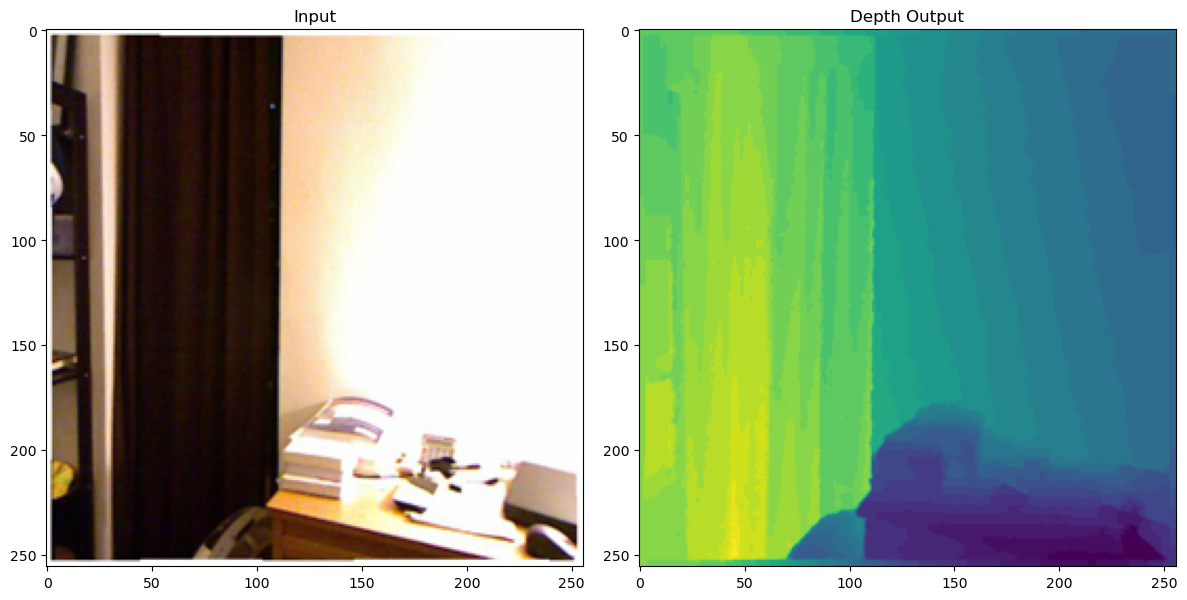

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 8))
axes = axes.flatten()

gen = data_generator(imageData, depthData, validIndices, 1)
sampleImage, sampleDepth = next(gen)

axes[0].imshow(sampleImage[0])
axes[0].set_title('Input')
axes[1].imshow(sampleDepth[0])
axes[1].set_title('Depth Output')

for ax in axes[3:5]:
    ax.axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# importing libraries to run dnn

In [10]:
from tensorflow.keras import initializers
initializer = initializers.RandomNormal(mean=0.0, stddev=1.0)

In [11]:
def hourglass_module(x, filters):
    # First Residual Block
    x_res1 = residual_block(x, filters)

    # Downsampling
    x_downsampled = MaxPooling2D((2, 2), padding='same')(x_res1)

    # Second Residual Block
    x_res2 = residual_block(x_downsampled, filters)

    # Upsampling
    x_upsampled = UpSampling2D((2, 2))(x_res2)

    # Skip connection to the original input
    x_skip = Conv2D(filters, (1, 1), padding='same', kernel_initializer='he_normal')(x)

    # Resize x_upsampled to match the shape of x_skip_resized
    x_upsampled_resized = tf.image.resize(x_upsampled, size=tf.shape(x_skip)[1:3], method='nearest')

    # Skip connection with the upsampled features
    x = Add()([x_skip, x_upsampled_resized])

    return x

def residual_block(x, filters, kernel_size=3, strides=1):
    y = Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
    y = Activation('sigmoid')(y)
    y = Conv2D(filters, kernel_size, padding='same')(y)

    # Adjust the shortcut connection to match the dimensions
    shortcut = Conv2D(filters, kernel_size=1, strides=strides, padding='same', kernel_initializer='he_normal')(x)
    y = Add()([y, shortcut])

    y = Activation('sigmoid')(y)
    return y

In [12]:
def encoder_decoder(input_shape, dropout=0.2, level_1_features=16, level_2_features=32, level_3_features=64):
    output_shape = input_shape[-1]
    # Input layer
    inputs = Input(shape=input_shape)

    # First convolution layer
    conv1 = Conv2D(level_1_features, (3, 3), padding='same', activation='sigmoid', kernel_initializer='he_normal')(inputs)
    conv1 = Dropout(dropout)(conv1)

    # Second convolution layer
    conv2 = Conv2D(level_1_features, (3, 3), padding='same', activation='sigmoid', kernel_initializer='he_normal')(conv1)
    conv2 = Dropout(dropout)(conv2)
#     conv2 = Activation('sigmoid')(conv2)

    # Third convolution layer
    conv3 = Conv2D(level_1_features, (3, 3), padding='same', activation='sigmoid', kernel_initializer='he_normal')(conv2)
    conv3 = Dropout(dropout)(conv3)
#     conv3 = Activation('sigmoid')(conv3)
    conv4Input = Add()([conv3, conv1])

    # Fourth convolution layer with a residual connection
    conv4 = Conv2D(level_2_features, (3, 3), padding='same', activation='sigmoid', kernel_initializer='he_normal')(conv4Input)
    conv4 = Dropout(dropout)(conv4)
#     conv4 = Activation('sigmoid')(conv4)
    
    #Max pooling after conv4
    conv4_pooled = MaxPooling2D((2, 2))(conv4)

    # fifth convolution layer 
    conv5 = Conv2D(level_2_features, (3, 3), padding='same', activation='sigmoid', kernel_initializer='he_normal')(conv4_pooled)
    conv5 = Dropout(dropout)(conv5)
#     conv5 = Activation('sigmoid')(conv5)
    
    # sixth convolution layer 
    conv6 = Conv2D(level_2_features, (3, 3), padding='same', activation='sigmoid', kernel_initializer='he_normal')(conv5)
    conv6 = Dropout(dropout)(conv6)
#     conv6 = Activation('sigmoid')(conv6)
    
    conv7Input = Add()([conv6, conv4_pooled])
    
    # seventh convolution layer with a residual connection
    conv7 = Conv2D(level_3_features, (3, 3), padding='same', activation='sigmoid', kernel_initializer='he_normal')(conv7Input)
    conv7 = Dropout(dropout)(conv7)
#     conv7 = Activation('sigmoid')(conv7)
    
    #Max pooling after conv7
    conv7_pooled = MaxPooling2D((2, 2), padding='same')(conv7)
    
    # eight convolution layer 
    conv8 = Conv2D(level_3_features, (3, 3), padding='same', activation='sigmoid', kernel_initializer='he_normal')(conv7_pooled)
    conv8 = Dropout(dropout)(conv8)
#     conv8 = Activation('sigmoid')(conv8)
    
    # nineth convolution layer 
    conv9 = Conv2D(level_3_features, (3, 3), padding='same', activation='sigmoid', kernel_initializer='he_normal')(conv8)
    conv9 = Dropout(dropout)(conv9)
#     conv9 = Activation('sigmoid')(conv9)
    
    conv10Input = Add()([conv9, conv7_pooled])
    
    #tenth convolutional layer with residual connection
    conv10 = Conv2D(level_3_features, (3, 3), padding='same', activation='sigmoid', kernel_initializer='he_normal')(conv10Input)
    conv10 = Dropout(dropout)(conv10)
#     conv10 = Activation('sigmoid')(conv10)
    
    #max pooling after conv10
    conv10_pooled = MaxPooling2D((2, 2), padding='same')(conv10)
    
    #This needs to fed into the Hour Glass
    
#     hourGlass1Output = hourglass_module(conv10_pooled, 64)
       # Stacked Hourglass
    hourglass = conv10_pooled
    for _ in range(4):  # You can adjust the number of stacked hourglass modules
        hourglass = hourglass_module(hourglass, 128) 
        
    for _ in range(4):  # You can adjust the number of stacked hourglass modules
        hourglass = hourglass_module(hourglass, 128) 
        

    dec_conv1 = UpSampling2D((2, 2))(hourglass)
    
    dec_conv2 = Conv2D(level_3_features, (3, 3), padding='same', activation='sigmoid', kernel_initializer='he_normal')(dec_conv1) # this output gets added to output of conv 4
    dec_conv2 = Dropout(dropout)(dec_conv2)

    dec_conv3 = Conv2D(level_3_features, (3, 3), padding='same', activation='sigmoid', kernel_initializer='he_normal')(dec_conv2)
    dec_conv3 = Dropout(dropout)(dec_conv3)
    
    dec_conv4 = Conv2D(level_3_features, (3, 3), padding='same', activation='sigmoid', kernel_initializer='he_normal')(dec_conv3)
    dec_conv4 = Dropout(dropout)(dec_conv4)
    
    dec_conv5Input = Add()([dec_conv4, dec_conv2])
    
    dec_conv5 = Conv2D(level_2_features, (3, 3), padding='same', activation='sigmoid', kernel_initializer='he_normal')(dec_conv5Input)
    dec_conv5 = Dropout(dropout)(dec_conv5)
    dec_conv6 = UpSampling2D((2, 2))(dec_conv5) # add this to output of conv 8
    
    dec_conv7 = Conv2D(level_2_features, (3, 3), padding='same', activation='sigmoid', kernel_initializer='he_normal')(dec_conv6)
    dec_conv7 = Dropout(dropout)(dec_conv7)
    dec_conv8 = Conv2D(level_2_features, (3, 3), padding='same', activation='sigmoid', kernel_initializer='he_normal')(dec_conv7)
    dec_conv8 = Dropout(dropout)(dec_conv8)
    
    dec_conv9Input = Add()([dec_conv8, dec_conv6])
    
    dec_conv9 = Conv2D(level_1_features, (3, 3), padding='same', activation='sigmoid', kernel_initializer='he_normal')(dec_conv9Input)
    dec_conv9 = Dropout(dropout)(dec_conv9)
    dec_conv10 = UpSampling2D((2, 2))(dec_conv9) # add this to output of conv 12

    dec_conv11 = Conv2D(level_1_features, (3, 3), padding='same', activation='sigmoid', kernel_initializer='he_normal')(dec_conv10)
    dec_conv11 = Dropout(dropout)(dec_conv11)
    dec_conv12 = Conv2D(level_1_features, (3, 3), padding='same', activation='sigmoid', kernel_initializer='he_normal')(dec_conv11)
    dec_conv12 = Dropout(dropout)(dec_conv12)
    
    dec_conv13Input = Add()([dec_conv12, dec_conv10])

    dec_conv13 = Conv2D(1, (3, 3), padding='same', activation='sigmoid', kernel_initializer='he_normal')(dec_conv13Input)
    
    model = tf.keras.models.Model(inputs=inputs, outputs=dec_conv13)
    return model

# checking that the encoder_decoder is working

In [13]:
# Getting Model dimensions
input_shape = (256, 256, 3)  # Adjust input shape as needed
model = encoder_decoder(input_shape, dropout=0.2)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                           

# Training the Model

1/1 [==============================] - 8s 8s/step
(256, 256, 1)
[[0.6922541  0.8218762  0.799192  ]
 [0.59125024 0.8489873  0.8284361 ]
 [0.57106775 0.8429981  0.8240515 ]]
0.8489872813224792 0.37772032618522644


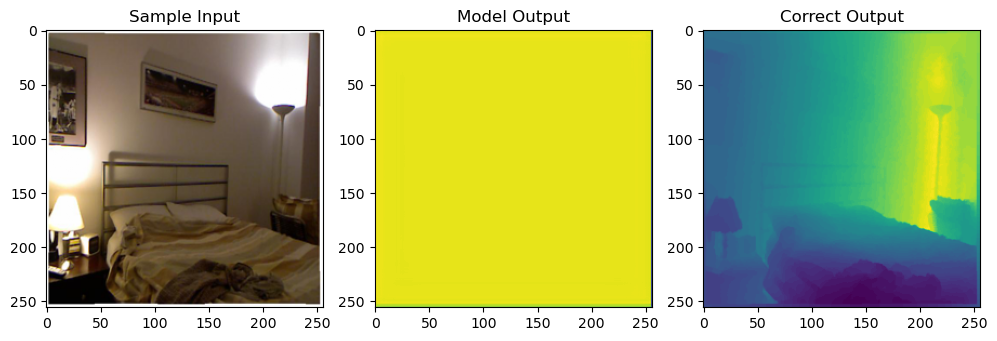

In [14]:
import matplotlib.pyplot as plt


# Get the model's prediction
sampleImage = 0
sampleDepth = 0

sampleInput = 0
sampleOutput = 0

for sample in valDataset.take(1):
    sampleInput = sample[0]
    sampleOutput = sample[1]
    sampleImage = sampleInput.numpy()
    sampleDepth = sampleOutput.numpy()

samplePrediction = model.predict(sampleInput)

samplePrediction = samplePrediction[0]  # Remove the batch dimension
print(samplePrediction.shape)
print(samplePrediction[0:3,0:3,0])
print(f"{np.max(samplePrediction)} {np.min(samplePrediction)}")


# Display the input and output images
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes = axes.flatten()

# Visualizing the input
axes[0].imshow(sampleImage[0])
axes[0].set_title('Sample Input')


axes[1].imshow(samplePrediction)  # You might need to adjust the color map
axes[1].set_title('Model Output')

axes[2].imshow(sampleDepth[0])
axes[2].set_title('Correct Output')

# Adjust spacing between subplots
plt.tight_layout()
plt.show()

In [15]:
optim1 = Adam(learning_rate=0.0001, clipnorm=3.0)
model.compile(optimizer=optim1, loss=MeanSquaredError())
model.fit(trainingDataset, epochs=10, steps_per_epoch=20)


Epoch 1/10


20/20 [==============================] - 25s 197ms/step - loss: 0.2556
Epoch 2/10
20/20 [==============================] - 4s 196ms/step - loss: 0.0844
Epoch 3/10
20/20 [==============================] - 4s 194ms/step - loss: 0.0341
Epoch 4/10
20/20 [==============================] - 4s 190ms/step - loss: 0.0230
Epoch 5/10
20/20 [==============================] - 4s 190ms/step - loss: 0.0187
Epoch 6/10
20/20 [==============================] - 4s 190ms/step - loss: 0.0170
Epoch 7/10
20/20 [==============================] - 4s 190ms/step - loss: 0.0162
Epoch 8/10
20/20 [==============================] - 4s 191ms/step - loss: 0.0163
Epoch 9/10
20/20 [==============================] - 4s 191ms/step - loss: 0.0173
Epoch 10/10
20/20 [==============================] - 4s 191ms/step - loss: 0.0171


1/1 [==============================] - 0s 22ms/step
(256, 256, 1)
[[0.16875018 0.08535716 0.08128081]
 [0.04190126 0.01384955 0.01255685]
 [0.03624006 0.01185284 0.01049759]]
0.16875018179416656 0.009640027768909931


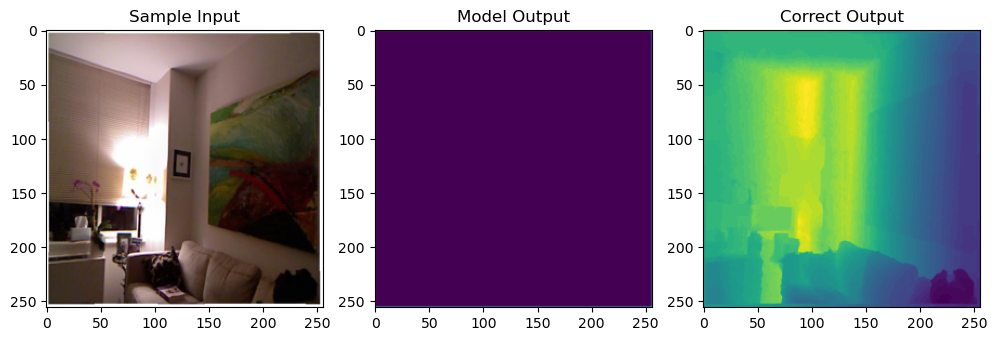

In [20]:
import matplotlib.pyplot as plt


# Get the model's prediction
sampleImage = 0
sampleDepth = 0

sampleInput = 0
sampleOutput = 0

for sample in valDataset.take(1):
    sampleInput = sample[0]
    sampleOutput = sample[1]
    sampleImage = sampleInput.numpy()
    sampleDepth = sampleOutput.numpy()

samplePrediction = model.predict(sampleInput)

samplePrediction = samplePrediction[0]  # Remove the batch dimension
print(samplePrediction.shape)
print(samplePrediction[0:3,0:3,0])
print(f"{np.max(samplePrediction)} {np.min(samplePrediction)}")


# Display the input and output images
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes = axes.flatten()

# Visualizing the input
axes[0].imshow(sampleImage[0])
axes[0].set_title('Sample Input')


axes[1].imshow(samplePrediction)  # You might need to adjust the color map
axes[1].set_title('Model Output')

axes[2].imshow(sampleDepth[0])
axes[2].set_title('Correct Output')

# Adjust spacing between subplots
plt.tight_layout()
plt.show()

In [17]:
optim2 = Adam(learning_rate=0.00005)
model.compile(optimizer=optim2, loss=paperLoss)

for i in range(1):
    model.fit(trainingDataset, epochs=20, steps_per_epoch=20)
    model.save('cnn_no_lstm_1.h5')

Epoch 1/20


20/20 [==============================] - 21s 323ms/step - loss: 21.3085
Epoch 2/20
20/20 [==============================] - 6s 323ms/step - loss: 18.1731
Epoch 3/20
20/20 [==============================] - 6s 322ms/step - loss: 15.5579
Epoch 4/20
20/20 [==============================] - 6s 322ms/step - loss: 13.3443
Epoch 5/20
20/20 [==============================] - 6s 322ms/step - loss: 11.4793
Epoch 6/20
20/20 [==============================] - 6s 322ms/step - loss: 9.7931
Epoch 7/20
20/20 [==============================] - 6s 323ms/step - loss: 8.4106
Epoch 8/20
20/20 [==============================] - 6s 322ms/step - loss: 7.3313
Epoch 9/20
20/20 [==============================] - 6s 323ms/step - loss: 6.2513
Epoch 10/20
20/20 [==============================] - 6s 323ms/step - loss: 5.5600
Epoch 11/20
20/20 [==============================] - 6s 323ms/step - loss: 4.8422
Epoch 12/20
20/20 [==============================] - 6s 324ms/step - loss: 4.4273
Epoch 13/20
20/20 [===========

In [18]:
from keras.models import load_model
model = load_model('cnn_no_lstm_1.h5', custom_objects={'paperLoss': paperLoss, 'encoder_decoder': encoder_decoder, 'hourglass_module': hourglass_module, 'residual_block': residual_block})

1/1 [==============================] - 0s 360ms/step
(256, 256, 1)
[[0.16875029 0.08535723 0.08128076]
 [0.04190119 0.01384958 0.01255683]
 [0.03624001 0.01185284 0.01049759]]
0.16875028610229492 0.009640064090490341


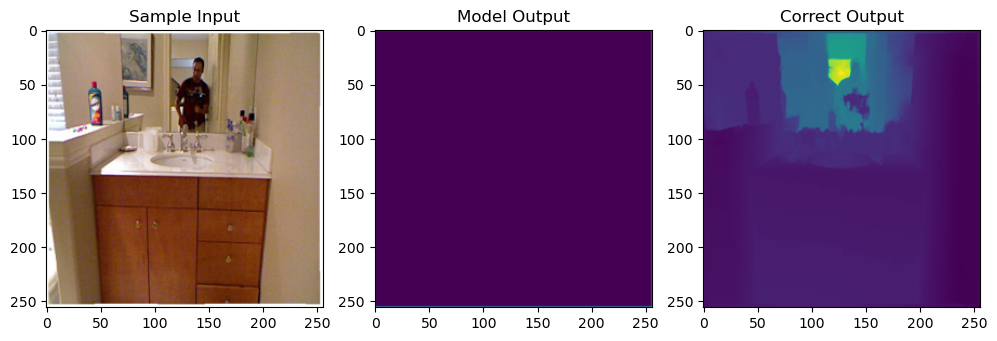

In [19]:
import matplotlib.pyplot as plt


# Get the model's prediction
sampleImage = 0
sampleDepth = 0

sampleInput = 0
sampleOutput = 0

for sample in valDataset.take(1):
    sampleInput = sample[0]
    sampleOutput = sample[1]
    sampleImage = sampleInput.numpy()
    sampleDepth = sampleOutput.numpy()

samplePrediction = model.predict(sampleInput)

samplePrediction = samplePrediction[0]  # Remove the batch dimension
print(samplePrediction.shape)
print(samplePrediction[0:3,0:3,0])
print(f"{np.max(samplePrediction)} {np.min(samplePrediction)}")


# Display the input and output images
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes = axes.flatten()

# Visualizing the input
axes[0].imshow(sampleImage[0])
axes[0].set_title('Sample Input')


axes[1].imshow(samplePrediction)  # You might need to adjust the color map
axes[1].set_title('Model Output')

axes[2].imshow(sampleDepth[0])
axes[2].set_title('Correct Output')

# Adjust spacing between subplots
plt.tight_layout()
plt.show()